In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_validation import train_test_split
import random
from sklearn.metrics import log_loss
from math import exp
import xgboost as xgb
from XGBoostPackage import xgbClass
from CrossValidation import CVScore
# from difflib import SequenceMatcher
import editdistance

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
random.seed(321)
np.random.seed(321)

X_train = pd.read_json("../input/train.json")
X_test = pd.read_json("../input/test.json")

In [3]:
interest_level_map = {'low': 0, 'medium': 1, 'high': 2}
X_train['interest_level'] = X_train['interest_level'].apply(lambda x: interest_level_map[x])
X_test['interest_level'] = -1
X_train['features'] = X_train["features"].apply(lambda x: " ".join(["_".join(i.strip().lower().split(" ")) for i in x]))
X_test['features'] = X_test["features"].apply(lambda x: " ".join(["_".join(i.strip().lower().split(" ")) for i in x]))

In [4]:
# def clean(x):
# #     x = s.replace("-", "")
# #     x = x.replace(" ", "")
# #     x = x.replace("twenty_four_hour", "24")
# #     x = x.replace("24/7", "24")
# #     x = x.replace("24hr", "24")
# #     x = x.replace("24-hour", "24")
# #     x = x.replace("24hour", "24")
# #     x = x.replace("24 hour", "24")
#     for i in ['24_hour_concierge/doorman','24/7_doorman_concierge',
#               '24-hour_doorman',
#               '24/7_concierge',
#               '24/7_doorman',
#               '24hr_doorman']+['24_hour_doorman']\
#     +['twenty-four_hour_concierge_and_doorman'\
#              ,'time_doorman','full-time_doorman','ft_doorman']:
#         x = x.replace(i, '24hr_doorman')
#     #x = x.replace("common", "cm")
#     for i in ['cable/satellite_tv', 'cable_ready']:
#         x = x.replace(i, 'cable')
#     for i in ["children's_playroom",
# #               'children\xe2\x80\x99s_playroom',
#               'childrens_playroom']:
#         x = x.replace(i, "children's_playroom")
#     #x = x.replace("concierge", "doorman")
#     #x = x.replace("bicycle", "bike")
#     for i in ['bicycle_room', 'bike_room', 'bike_storage']:
#         x = x.replace(i, 'bike_room')
#     for i in ['billiards_room',
#               'billiards_table_and_wet_bar']:
#         x = x.replace(i, 'billiards')
#     for i in ['concierge_service', 'concierge', 'doorman_service', 'doorman'
#              ]:
#         x = x.replace(i, 'doorman')
#     #x = x.replace("private", "pv")
#     #x = x.replace("deco", "dc")
#     #x = x.replace("decorative", "dc")
#     x = x.replace('deco_brick_walls', 'deco_brick_wall')
#     x = x.replace('decorative_fireplace','deco_fireplace')
#     x = x.replace('dish_washer', 'dishwasher')
#     x = x.replace('_exposed_brick_','exposed_brick')
#     #x = x.replace("onsite", "os")
#     #x = x.replace("outdoor", "od")
#     for i in ['fitness_center', 'fitness_facility', 'fitness_room']\
#     +['gym/fitness','gym_in_building']:
#         x = x.replace(i, 'gym')
#     x = x.replace('fireplaces','fireplace')
#     for i in ['eat-in_kitchen'\
#              ,'in_kitchen_', 'in_kitchen','eat_in_kitchen','s_kitchen_','_kitchen_'\
#              ,'eat_kitchen'\
#              ,'_skitchen']:
#         x = x.replace(i,'kitchen')
# #     x = x.replace("ft","full-time")
#     for i in ['granite_countertops',
#               'granite_counter_tops',
#               'granite_counters',
#               'granite_counter',
#               'granite_kitchen']:
#         x = x.replace(i, 'granite')
#     for i in ['hardwood_floors','hardwood_floor']:
#         x = x.replace(i, 'hardwood')
#     x = x.replace('high_ceilings','high_ceiling')
#     for i in ['high-speed_internet',
# #               'high_floor',
# #              'high_speed_internet',
#               'high_speed_internet_available']:
# #               'highrise']:
#         x = x.replace(i, 'high_speed_internet')
#     x = x.replace('large_living-room', 'large_living_room')
#     x = x.replace('laundry_on_every_floor','laundry_on_floor')
#     x = x.replace('marble_bathroom','marble_bath')
#     x = x.replace('media_screening_room','media_room')
#     x = x.replace('multi-level', 'multi_level')
#     for i in ['parking_space','on-site_parking',
#               'on-site_parking_available',
#               'parking_available',
#               'on-site_parking_lot']\
#     :
#         x = x.replace(i, 'parking')
#     for i in ['pets:_cats/small_dogs',
#               'pets_allowed',
#               #'cats_allowed','dogs_allowed',
#               'pets_on_approval']\
#     +['all_pets_ok','_pets_ok_','pet_friendly']\
#     :
#         x = x.replace(i, 'pets')
#     for i in ['pre_war']+['pre-war', 'prewar', 'pre']:
#         x = x.replace(i, 'pre')
#     for i in ['post-war', 'post_war', 'postwar', 'post']:
#         x = x.replace(i, 'post')
#     x = x.replace('publicoutdoor','outdoor')
#     for i in ['common_roof_deck','common_roof',
#               'roof-deck',
#               'roof_access',
#               'roof_decks',
#               'roof_deck',
#               #'roof_deck_with_grills',
#               'rooftop_deck',
#               'roofdeck',
#               'rooftop_terrace',
#               'rooftop']:
#         x = x.replace(i,'roof')
#     x = x.replace('shares_ok','share_ok')
#     for i in ["ss appliances", 
#               'stainless_steel_appliances',
#               'stainless_steel_kitchen',
#              'stainless_steel']:
#         x = x.replace(i, "stainless")
#     for i in ['storage_available',
#               'storage_facilities_available',
#               'storage_room',
#               'storage_space']:
#         x = x.replace(i, 'storage')
#     for i in ['super_on-site', 'on-site_super']+['live-in_super',
#               'live-in_superintendent',
#               'live/work',
#               'live_in_super','site_super','superintendent']:
#         x = x.replace(i, 'super')
#     x.replace('swimming_pool', 'pool')
#     for i in ['valet_laundry',
# #               'valet_parking',
#               'valet_services',
#               'valet_services_(housekeeping/dry_cleaning_available)',
#               'valet_services_including_dry_cleaning','laundry_&_housekeeping',
#               'valet_service']:
#         x = x.replace(i, 'valet')
#     for i in ['washer/dryer_in-unit','washer_in_unit', 'laundry_in_unit','dryer_in_unit']:
#         x = x.replace(i,'washer_in_unit')    
#     for i in [#'walk-up',
# #              'walk_in_closet',
#               'walk_in_closet(s)',
#               'closet_space',
#               'walk-in_closet',
#              ]:
#         x = x.replace(i, 'closet')
#     for i in ['dry_cleaning_service',
#               'washer/dryer_hookup',
#               'washer/dryer_in_bldg',
#               'washer/dryer_in_building',              
#               'washer_&_dryer','laundry_in_building','laundry_room',
#               'site_laundry','_washer','dryer']:
#         x = x.replace(i, 'laundry')
#     x = x.replace('wheelchair_ramp', 'wheelchair_access')
#     for i in ['wi-fi_access',
#               'wifi_access',
#               'wifi_in_resident_lounge']+['free_wifi', 'free_wifi_in_club_lounge']:
#         x = x.replace(i, 'wifi')
#     return x

In [5]:
# print(X_train.shape)
# X_train['features']=X_train['features'].apply(clean)
# X_test['features']=X_test['features'].apply(clean)
# X_train.head(1)

In [6]:
# X_train['features'].head(20)

In [4]:
#add features
feature_transform = CountVectorizer(stop_words='english', max_features=150)
# X_train['features'] = X_train["features"].apply(lambda x: " ".join(["_".join(i.lower().split(" ")) for i in x]))
# X_test['features'] = X_test["features"].apply(lambda x: " ".join(["_".join(i.lower().split(" ")) for i in x]))
feature_transform.fit(list(X_train['features']) + list(X_test['features']))

train_size = len(X_train)
low_count = len(X_train[X_train['interest_level'] == 0])
medium_count = len(X_train[X_train['interest_level'] == 1])
high_count = len(X_train[X_train['interest_level'] == 2])

In [5]:
def find_objects_with_only_one_record(feature_name):
    temp = pd.concat([X_train[feature_name].reset_index(), 
                      X_test[feature_name].reset_index()])
    temp = temp.groupby(feature_name, as_index = False).count()
    return temp[temp['index'] == 1]

managers_with_one_lot = find_objects_with_only_one_record('manager_id')
buildings_with_one_lot = find_objects_with_only_one_record('building_id')
addresses_with_one_lot = find_objects_with_only_one_record('display_address')


In [21]:
def calculate_average(sub1, sub2):
        g1=sub1.groupby(variable).count()['y']
        g2=sub1[sub1['y']==1].groupby(variable).count()['y']
        def CV_stat(M_id):
            if M_id in g2.index:
                return g2[M_id]/(g1[M_id])
            return 0
        tmp=sub2[variable].apply(CV_stat)
        return tmp.ravel()

In [23]:
variable='manager_id'
y='medium'
feature_name="manager_id_CV_medium"
k_fold = StratifiedKFold(5)
X_train[feature_name] = -999 
for (train_index, cv_index) in k_fold.split(np.zeros(len(X_train)),
                                                X_train['interest_level'].ravel()):
    sub = pd.DataFrame(data = {variable: X_train[variable],
                                   'y': X_train[y]})
            
    sub1 = sub.iloc[train_index]        
    sub2 = sub.iloc[cv_index]
    g1=sub1.groupby(variable).count()['y']
    g2=sub1[sub1['y']==1].groupby(variable).count()['y']
    def CV_stat(M_id):
        if M_id in g2.index:
            return g2[M_id]/(g1[M_id]+1e-10)
        return 0;
    tmp=sub2[variable].iloc[:].apply(CV_stat)
    print(tmp.ravel())
    #print(calculate_average(sub1, sub2))
#sub2[variable].iloc[0]

[ 0.28358209  0.0125      0.35789474 ...,  0.375       0.3         0.5       ]
[ 0.16666667  0.17333333  0.08885017 ...,  0.36956522  0.26086957
  0.34693878]
[ 0.41558442  0.31578947  0.34782609 ...,  0.2173913   0.3125      0.2       ]
[ 0.4         0.18181818  0.36538462 ...,  0.58823529  0.35294118  0.4       ]
[ 0.14285714  0.24328358  0.17674419 ...,  1.          0.          0.1       ]


In [19]:
g1=sub1.groupby(variable).count()['y']
g2=sub1[sub1['y']==1].groupby(variable).count()['y']
def CV_stat(M_id):
    if M_id in g2.index:
        return g2[M_id]/(g1[M_id]+1e-10)
    return 0;
tmp=sub2[variable].iloc[:].apply(CV_stat)
tmp.ravel()

array([ 0.14285714,  0.24328358,  0.17674419, ...,  1.        ,
        0.        ,  0.1       ])

In [24]:
def categorical_average(variable='manager_id', y='medium'\
                        , feature_name="manager_id_CV_medium"):
    def calculate_average(sub1, sub2):
        g1=sub1.groupby(variable).count()['y']
        g2=sub1[sub1['y']==1].groupby(variable).count()['y']
        def CV_stat(M_id):
            if M_id in g2.index:
                return g2[M_id]/(g1[M_id])
            return 0
        tmp=sub2[variable].apply(CV_stat)
        return tmp.ravel()
     
    #cv for training set 
    k_fold = StratifiedKFold(5)
    X_train[feature_name] = -999 
    for (train_index, cv_index) in k_fold.split(np.zeros(len(X_train)),
                                                X_train['interest_level'].ravel()):
        sub = pd.DataFrame(data = {variable: X_train[variable],
                                   'y': X_train[y]})
            
        sub1 = sub.iloc[train_index]        
        sub2 = sub.iloc[cv_index]
        g1=sub1.groupby(variable).count()['y']
        g2=sub1[sub1['y']==1].groupby(variable).count()['y']
        def CV_stat(M_id):
            if M_id in g2.index:
                return g2[M_id]/(g1[M_id]+1e-10)
            return 0;
        X_train.loc[cv_index, feature_name]=sub2[variable].iloc[:].apply(CV_stat)
        #X_train.loc[cv_index, feature_name] = calculate_average(sub1, sub2)
    
    #for test set
    sub1 = pd.DataFrame(data = {variable: X_train[variable],
                                'y': X_train[y]})
    sub2 = pd.DataFrame(data = {variable: X_test[variable],
                                'y': X_test[y]})
    X_test.loc[:, feature_name] = calculate_average(sub1, sub2)                               


In [12]:
# def categorical_average(variable='manager_id', y='medium'\
#                         , feature_name="manager_id_CV_medium", X_train=X_train):
#     def calculate_average(train_index, cv_index):
#         tmp=sub2[variable].apply(lambda x: len(sub1[(sub1[variable]==x)&(sub1['y']==1)])\
#                        /(len(sub1[sub1[variable]==x])+1e-10))
#         return tmp.ravel()
     
#     #cv for training set 
#     k_fold = StratifiedKFold(5)
#     X_train[feature_name] = -999 
#     for (train_index, cv_index) in k_fold.split(np.zeros(len(X_train)),
#                                                 X_train['interest_level'].ravel()):
#         sub = pd.DataFrame(data = {variable: X_train[variable],
#                                    'y': X_train[y]})
            
#         sub1 = sub.iloc[train_index]        
#         sub2 = sub.iloc[cv_index]
        
#         X_train.loc[cv_index, feature_name] = calculate_average(train_index, cv_index)
    
#     #for test set
#     sub1 = pd.DataFrame(data = {variable: X_train[variable],
#                                 'y': X_train[y]})
#     sub2 = pd.DataFrame(data = {variable: X_test[variable],
#                                 'y': X_test[y]})
#     X_test.loc[:, feature_name] = calculate_average(sub1, sub2)                               


In [7]:
def transform_data(X):
    #add features    
    feat_sparse = feature_transform.transform(X["features"])
    vocabulary = feature_transform.vocabulary_
    del X['features']
    X1 = pd.DataFrame([ pd.Series(feat_sparse[i].toarray().ravel()) for i in np.arange(feat_sparse.shape[0]) ])
    X1.columns = list(sorted(vocabulary.keys()))
    X = pd.concat([X.reset_index(), X1.reset_index()], axis = 1)
    del X['index']
    
    X["num_photos"] = X["photos"].apply(len)
    X['created'] = pd.to_datetime(X["created"])
    X["num_description_words"] = X["description"].apply(lambda x: len(x.split(" ")))
    X['price_per_bed'] = X['price'] / X['bedrooms']    
    X['price_per_bath'] = X['price'] / X['bathrooms']
    X['price_per_room'] = X['price'] / (X['bathrooms'] + X['bedrooms'] )
    
    X['low'] = 0
    X.loc[X['interest_level'] == 0, 'low'] = 1
    X['medium'] = 0
    X.loc[X['interest_level'] == 1, 'medium'] = 1
    X['high'] = 0
    X.loc[X['interest_level'] == 2, 'high'] = 1
    
    X['display_address'] = X['display_address'].apply(lambda x: x.lower().strip())
    X['street_address'] = X['street_address'].apply(lambda x: x.lower().strip())
#     def similar(a, b):
#         return SequenceMatcher(None, a, b).ratio()
#     X['display_street_dist']=X.apply(lambda row: similar(row['display_address'], row['street_address']), axis=1)
    X['display_street_dist']=X.apply(lambda row: editdistance.eval\
                                     (row['display_address'], row['street_address']), axis=1)
    
#     X['pred0_low'] = low_count * 1.0 / train_size
#     X['pred0_medium'] = medium_count * 1.0 / train_size
#     X['pred0_high'] = high_count * 1.0 / train_size
    
    X.loc[X['manager_id'].isin(managers_with_one_lot['manager_id'].ravel()), 
          'manager_id'] = "-1"
    X.loc[X['building_id'].isin(buildings_with_one_lot['building_id'].ravel()), 
          'building_id'] = "-1"
    X.loc[X['display_address'].isin(addresses_with_one_lot['display_address'].ravel()), 
          'display_address'] = "-1"
          
    return X

def normalize_high_cordiality_data():
    high_cardinality = ["building_id", "manager_id"]
    for c in high_cardinality:
        categorical_average(c, "medium", c + "_mean_medium")
        categorical_average(c, "high", c + "_mean_high")

def transform_categorical_data():
    categorical = ['building_id', 'manager_id', 
                   'display_address', 'street_address']
                   
    for f in categorical:
        encoder = LabelEncoder()
        encoder.fit(list(X_train[f]) + list(X_test[f])) 
        X_train[f] = encoder.transform(X_train[f].ravel())
        X_test[f] = encoder.transform(X_test[f].ravel())
                  

def remove_columns(X):
    columns = ["photos", #"pred0_high", "pred0_low", "pred0_medium",
               "description", "low", "medium", "high",
               "interest_level", "created"]
    for c in columns:
        del X[c]

In [8]:
print("Starting transformations")        
X_train = transform_data(X_train)    
X_test = transform_data(X_test) 
y_train = X_train['interest_level'].ravel()


Starting transformations


In [25]:
print("Normalizing high cordiality data...")
normalize_high_cordiality_data()
transform_categorical_data()

Normalizing high cordiality data...


In [26]:
X_train[['manager_id_mean_medium','manager_id_mean_high']]

,manager_id_mean_medium,manager_id_mean_high
0,0.283582,0.000000
1,0.012500,0.000000
2,0.357895,0.031579
3,0.152542,0.084746
4,0.000000,0.000000
5,0.085366,0.012195
6,0.000000,0.000000
7,0.223200,0.066805
8,0.307692,0.179487
9,0.625000,0.125000


In [32]:
(X_train['interest_level'])[(X_train['dogs_allowed']==1)&(X_train['cats_allowed']==1)]

1        0
6        0
8        1
13       0
18       0
19       0
22       0
23       0
24       1
30       1
31       1
32       0
34       0
35       0
36       0
37       2
39       1
41       0
45       1
47       0
49       0
58       1
62       0
63       0
65       0
67       0
70       0
72       0
73       0
75       0
        ..
49289    1
49291    0
49292    0
49293    0
49294    0
49297    0
49299    0
49300    0
49303    0
49306    0
49309    0
49314    0
49317    2
49318    0
49320    1
49322    0
49323    0
49324    1
49326    0
49328    0
49329    0
49332    0
49333    0
49334    0
49338    0
49341    0
49342    2
49348    0
49349    0
49350    0
Name: interest_level, dtype: int64

In [27]:
remove_columns(X_train)
remove_columns(X_test)

In [28]:
print(X_train.shape)
X_train.head(2)

(49352, 170)


,bathrooms,bedrooms,building_id,display_address,latitude,listing_id,longitude,manager_id,price,street_address,...,num_description_words,price_per_bed,price_per_bath,price_per_room,display_street_dist,building_id_mean_medium,building_id_mean_high,manager_id_mean_medium,manager_id_mean_high,manager_id_CV_medium
0,1.5,3,2103,10443,40.7145,7211212,-73.9425,1203,3000,21630,...,95,1000.0,2000.0,666.666667,4,0.000000,0.0,0.283582,0.0,-999
1,1.0,2,5077,7525,40.7947,7150865,-73.9667,1518,5465,21801,...,9,2732.5,5465.0,1821.666667,4,0.111111,0.0,0.012500,0.0,-999


In [29]:
featuresInUse = [f for f in X_train.columns if f not in ['manager_id', 'building_id', "display_address"]\
#                   +['war','eat','on','building']                                       
                ]
                                                        #,'no_pets','_pets_ok_','bedrooms', 'dryer_in_unit',
                                                        #'health_club','common', 
#                  +list(imp.sort_values("train").head(10).index)]
#featuresInUse = [f for f in X_train.columns if f not in []]
len(featuresInUse)

167

In [30]:
#cross validation

X_fit, X_val, y_fit, y_val=train_test_split(X_train[featuresInUse][:], y_train[:], test_size=0.33, random_state=42)

In [31]:
param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.1
param['max_depth'] = 4
param['silent'] = 1
param['num_class'] = 3
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 1
param['subsample'] = 0.7
param['colsample_bytree'] = 0.7
param['seed'] = 321
param['nthread'] = 8
num_rounds = 1000


In [32]:
xgfit = xgb.DMatrix(X_fit, label=y_fit)
xgval = xgb.DMatrix(X_val, label=y_val)
watchlist = [ (xgfit,'train'), (xgval, 'test') ]
clfCV = xgb.train(param, xgfit, num_rounds)
#clfCV = xgb.train(param, xgfit, num_rounds, watchlist, early_stopping_rounds=20)

y_val_pred = clfCV.predict(xgval)
log_loss(y_val, y_val_pred)
#0.535112: 2000, f not in ['manager_id', 'building_id', "display_address"\,'common_roof_deck']]

0.54196367884836971

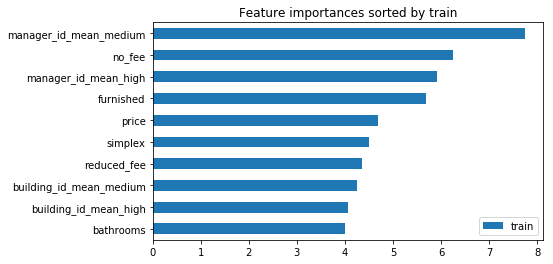

In [33]:
imp=pd.DataFrame()#(index=features_to_use)
imp['train'] = pd.Series(clfCV.get_score(importance_type='gain'))#, index=features_to_use)
imp = imp.fillna(0)
ax=imp.sort_values('train').tail(10).plot.barh(title='Feature importances sorted by train', figsize=(7,4))

In [34]:
print(len(imp))
imp.sort_values('train',ascending=False).head(45)

135


,train
manager_id_mean_medium,7.735448
no_fee,6.247141
manager_id_mean_high,5.906858
furnished,5.691853
price,4.681615
simplex,4.491503
reduced_fee,4.356296
building_id_mean_medium,4.246470
building_id_mean_high,4.058515
bathrooms,4.008744


In [35]:
imp.sort_values('train',ascending=False).tail(50)

,train
site_super,1.730234
loft,1.710746
high_ceiling,1.709547
publicoutdoor,1.690420
bike_room,1.685280
dining_room,1.661566
luxury_building,1.656052
space,1.627782
live_in_super,1.570084
24,1.560272


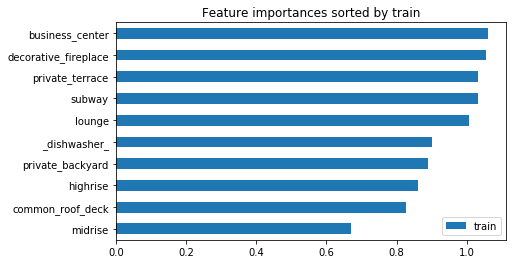

In [36]:
ax=imp.sort_values('train').head(10).plot.barh(title='Feature importances sorted by train', figsize=(7,4))

In [37]:
X_train[featuresInUse][:1]

,bathrooms,bedrooms,latitude,listing_id,longitude,price,street_address,24,_dishwasher_,_dryer,...,num_description_words,price_per_bed,price_per_bath,price_per_room,display_street_dist,building_id_mean_medium,building_id_mean_high,manager_id_mean_medium,manager_id_mean_high,manager_id_CV_medium
0,1.5,3,40.7145,7211212,-73.9425,3000,21630,0,0,0,...,95,1000.0,2000.0,666.666667,4,0.0,0.0,0.283582,0.0,-999


In [24]:
param_grid = {'eta':[.02, .05], 'num_round':[1500,2000,2500], 'subsample':[.7], 'colsample_bytree':[.65,.85], \
              'max_depth':[4,5], 'seed':[2017]}
for eta in param_grid['eta']:
    for subsample in param_grid['subsample']:
        for colsample_bytree in param_grid['colsample_bytree']:
            for max_depth in param_grid['max_depth']:
                for seed in param_grid['seed']:
                    for num_rounds in param_grid['num_round']:
                        model=xgbClass(colsample_bytree=colsample_bytree, eta=eta, eva_metric='mlogloss', \
                                       subsample=subsample, max_depth=max_depth, seed=seed,\
                                       objective='multi:softprob', num_class=3,num_rounds=num_rounds)
                        score=CVScore(model=model, my_score=log_loss, X_train=(X_train[featuresInUse])[:100],\
                                  y_train=y_train[:100])
                        del model
                        print('eta={}, subsample={}, colsample_bytree={}, max_depth={}, seed={}, score={}, num_rounds={}'.\
                          format(eta, subsample, colsample_bytree, max_depth, seed, score, num_rounds))

eta=0.02, subsample=0.7, colsample_bytree=0.65, max_depth=4, seed=2017, score=1.05677167543, num_rounds=1500
eta=0.02, subsample=0.7, colsample_bytree=0.65, max_depth=4, seed=2017, score=1.08321649204, num_rounds=2000
eta=0.02, subsample=0.7, colsample_bytree=0.65, max_depth=4, seed=2017, score=1.10272785452, num_rounds=2500
eta=0.02, subsample=0.7, colsample_bytree=0.65, max_depth=5, seed=2017, score=1.0581438732, num_rounds=1500
eta=0.02, subsample=0.7, colsample_bytree=0.65, max_depth=5, seed=2017, score=1.08491223451, num_rounds=2000
eta=0.02, subsample=0.7, colsample_bytree=0.65, max_depth=5, seed=2017, score=1.10364146405, num_rounds=2500
eta=0.02, subsample=0.7, colsample_bytree=0.85, max_depth=4, seed=2017, score=1.07095665254, num_rounds=1500
eta=0.02, subsample=0.7, colsample_bytree=0.85, max_depth=4, seed=2017, score=1.09563050426, num_rounds=2000
eta=0.02, subsample=0.7, colsample_bytree=0.85, max_depth=4, seed=2017, score=1.11406079073, num_rounds=2500
eta=0.02, subsample=

In [14]:
print("Start fitting...")

# param = {}
# param['objective'] = 'multi:softprob'
# param['eta'] = 0.02
# param['max_depth'] = 4
# param['silent'] = 1
# param['num_class'] = 3
# param['eval_metric'] = "mlogloss"
# param['min_child_weight'] = 1
# param['subsample'] = 0.7
# param['colsample_bytree'] = 0.7
# param['seed'] = 321
# param['nthread'] = 8
# num_rounds = 2000

xgtrain = xgb.DMatrix(X_train[featuresInUse], label=y_train)
clf = xgb.train(param, xgtrain, num_rounds)

print("Fitted")

def prepare_submission(model):
    xgtest = xgb.DMatrix(X_test[featuresInUse])
    preds = model.predict(xgtest)    
    sub = pd.DataFrame(data = {'listing_id': X_test['listing_id'].ravel()})
    sub['low'] = preds[:, 0]
    sub['medium'] = preds[:, 1]
    sub['high'] = preds[:, 2]
    sub.to_csv("It_is_lit2.csv", index = False, header = True)

prepare_submission(clf)

Start fitting...
Fitted
